In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib ipympl
from pathlib import Path
import seaborn as sns
import umap
import time
import skdim
import tensorflow as tf
from tensorflow.keras import layers, models
from keras_tuner import HyperModel, RandomSearch
from spatialinfo import spatial_information as si
from spatialinfo import dimensionality_utils as du

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import matplotlib.cm as cm


## LOAD DATA

In [45]:
dff, bh = si.load_data(Path('..\\data\\processed_datasets\\20240903_Dc_1\\'))
bh = si.remove_interpolated_values(bh, n_corr=2)
bh = si.add_trial_column(bh)
activity_data, spatial_data = si.temporal_binning(dff, bh, sec_per_bin=0.5, only_moving=False)

In [46]:
np.shape(activity_data)

(3697, 366)

## COMPUTE DIMENSIONALITY
The angle-based intrinsic dimensionality (ABID) estimate was introduced by [Thordsen & Schubert (2022)](https://doi.org/10.1016/j.is.2022.101989). In short, for each point of a dataset x nearest neighbors are found according to some distance metric. From the paper:

"Definition 1 (ABID) . Given a data set $X = { x_1 , . . . , x_n }⊂ \mathbb{R}^D$ , the regularized angle-based intrinsic dimensionality estimator for a point x i is: $ID_{ABID}( x_i ; k ) := \mathbb{E} [ C_1 ( B_k ( x_i ))^2 ] ^{− 1}$ where $B_k ( x_i )$ are the directional vectors from $x_i$ to the k nearest neighbors of $x_i$ and $C_1 ( B_k ( x_i ))$ are the pairwise cosine similarities within $B_k ( x_i )$."

In [50]:

abid_dim = du.compute_abids(activity_data)
print(f"ABID: {np.nanmean(abid_dim):.2f}", end='', flush=True)
time.sleep(.2)
    
mom_dim = skdim.id.MOM().fit_transform(activity_data,n_neighbors = 25)
print(f" | MOM: {mom_dim:.2f}", end='', flush=True)
time.sleep(.2)

tle_dim = skdim.id.TLE().fit_transform(activity_data,n_neighbors = 25)
print(f" | TLE: {tle_dim:.2f}", flush=True)
time.sleep(.2)

ABID: 3.72

 | MOM: 9.10 | TLE: 8.15


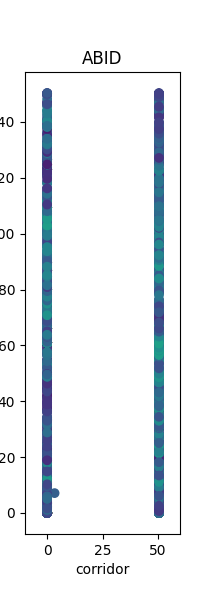

In [62]:
# display how ABID maps to behavior space

df = np.column_stack((spatial_data, abid_dim))

fig, ax = plt.subplots(figsize=(2, 6))
ax.scatter(x=df[:,0], y=df[:,1], c=df[:,2], cmap='viridis')
ax.set(title='ABID', xlabel='corridor', ylabel='position')
ax.set_xlim([-10,60])
plt.show()

## COMPUTE UMAP

In [48]:
#model = umap.UMAP(n_neighbors =50, n_components =3, min_dist=0.08, metric="correlation")
model = umap.UMAP(n_neighbors =30, n_components =3, min_dist=0.1, metric="correlation")
model.fit(activity_data)
concat_emb = model.transform(activity_data)
np.shape(spatial_data)

(3697, 2)

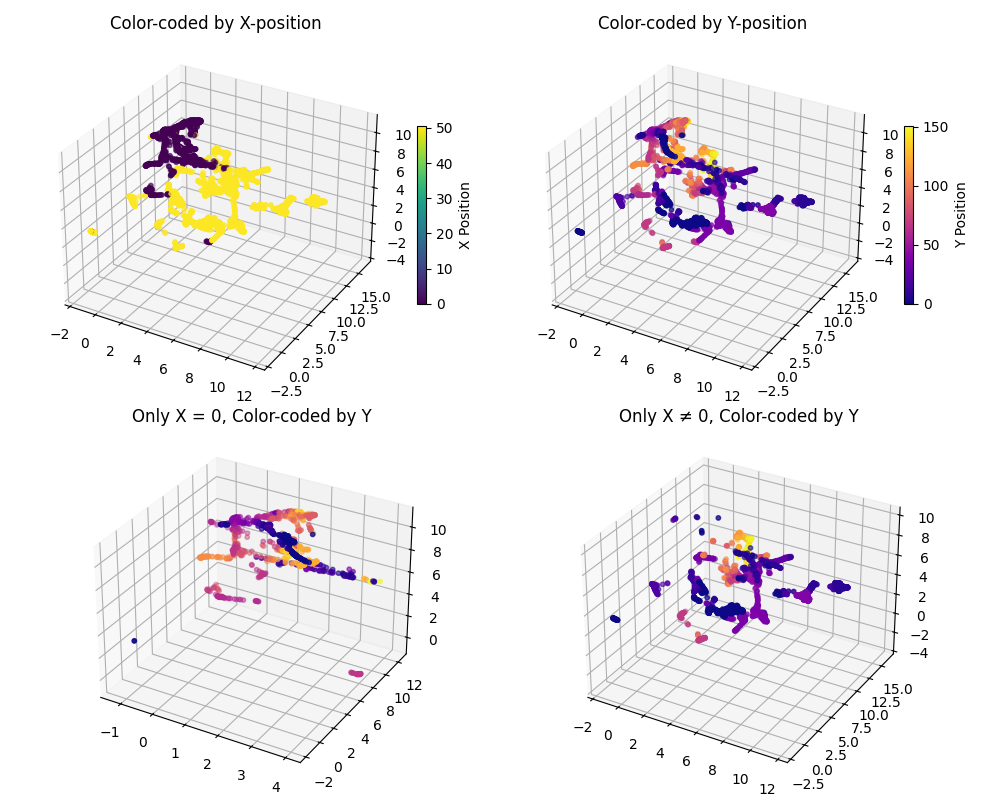

In [49]:
# Normalize x and y separately for color mapping
norm_x = Normalize(vmin=spatial_data[:, 0].min(), vmax=spatial_data[:, 0].max())
norm_y = Normalize(vmin=spatial_data[:, 1].min(), vmax=spatial_data[:, 1].max())

colors_x = cm.viridis(norm_x(spatial_data[:, 0]))  # Color by x
colors_y = cm.plasma(norm_y(spatial_data[:, 1]))  # Color by y

# Filter points where x = 0 and x ≠ 0
mask_x0 = spatial_data[:, 0] == 0
mask_x_nonzero = spatial_data[:, 0] != 0

# Create figure and 3D subplots
fig = plt.figure(figsize=(10, 8))

# Subplot 1: Color-coded by x-position
ax1 = fig.add_subplot(221, projection='3d')
sc1 = ax1.scatter(concat_emb[:, 0], concat_emb[:, 1], concat_emb[:, 2], c=colors_x, s=10)
ax1.set_title("Color-coded by X-position")


# Add colorbar for x
sm_x = cm.ScalarMappable(cmap="viridis", norm=norm_x)
sm_x.set_array([])
cbar_x = plt.colorbar(sm_x, ax=ax1, shrink=0.5)
cbar_x.set_label("X Position")

# Subplot 2: Color-coded by y-position
ax2 = fig.add_subplot(222, projection='3d')
sc2 = ax2.scatter(concat_emb[:, 0], concat_emb[:, 1], concat_emb[:, 2], c=colors_y, s=10)
ax2.set_title("Color-coded by Y-position")


# Add colorbar for y
sm_y = cm.ScalarMappable(cmap="plasma", norm=norm_y)
sm_y.set_array([])
cbar_y = plt.colorbar(sm_y, ax=ax2, shrink=0.5)
cbar_y.set_label("Y Position")

# Subplot 3: Only x = 0, color-coded by y-position
ax3 = fig.add_subplot(223, projection='3d')
sc3 = ax3.scatter(concat_emb[mask_x0, 0], concat_emb[mask_x0, 1], concat_emb[mask_x0, 2], 
                  c=cm.plasma(norm_y(spatial_data[mask_x0, 1])), s=10)
ax3.set_title("Only X = 0, Color-coded by Y")


# Subplot 4: Only x ≠ 0, color-coded by y-position
ax4 = fig.add_subplot(224, projection='3d')
sc4 = ax4.scatter(concat_emb[mask_x_nonzero, 0], concat_emb[mask_x_nonzero, 1], concat_emb[mask_x_nonzero, 2], 
                  c=cm.plasma(norm_y(spatial_data[mask_x_nonzero, 1])), s=10)
ax4.set_title("Only X ≠ 0, Color-coded by Y")


plt.tight_layout()
plt.show()